In [ ]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [ ]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [ ]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['binary_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_binary_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

In [ ]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [ ]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict(generator_test, steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [ ]:
#Importing general libraries
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os
import cv2
import albumentations as A  
from google.colab.patches import cv2_imshow


In [ ]:
!pip show tensorflow

In [ ]:
#Importing libraries
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from google.colab import drive
import tensorflow as tf

In [ ]:
#Import Parkinson's DATASET
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/PD_Dataset/4Dataset.zip'

In [ ]:
train_dir = '/content/4Dataset/train'
test_dir = '/content/4Dataset/val'
print(len(os.listdir('/content/4Dataset/train/HC')))
print(len(os.listdir('/content/4Dataset/train/PD')))
print(len(os.listdir('/content/4Dataset/val/HC')))
print(len(os.listdir('/content/4Dataset/val/PD')))

671
875
75
98


In [ ]:
import os
import pandas as pd

# Ruta de la carpeta principal de la base de datos
base_path = '/content/2Dataset/train'

# Obtener las subcarpetas dentro de la carpeta principal
subfolders = os.listdir(base_path)

# Inicializar listas para almacenar los nombres de las imágenes y las etiquetas
image_names = []
labels = []

# Iterar sobre las subcarpetas
for subfolder in subfolders:
    # Obtener la ruta completa de la subcarpeta
    subfolder_path = os.path.join(base_path, subfolder)
    
    # Obtener la lista de archivos dentro de la subcarpeta
    files = os.listdir(subfolder_path)
    
    # Iterar sobre los archivos de la subcarpeta
    for file in files:
        # Obtener el nombre de la imagen y la etiqueta de la subcarpeta
        image_name = file
        label = subfolder
        
        # Agregar el nombre de la imagen y la etiqueta a las listas
        image_names.append(image_name)
        labels.append(label)

# Crear un DataFrame con las columnas "Image" y "Label"
df_train = pd.DataFrame({'Image': image_names, 'Label': labels})

# Imprimir el DataFrame
print(df_train)


           Image Label
0      HC_30.jpg    HC
1     HC_278.jpg    HC
2     HC_539.jpg    HC
3      HC_68.jpg    HC
4     HC_482.jpg    HC
...          ...   ...
1464  PD_378.jpg    PD
1465  PD_889.jpg    PD
1466   PD_51.jpg    PD
1467  PD_774.jpg    PD
1468  PD_867.jpg    PD

[1469 rows x 2 columns]


In [ ]:
import os
import pandas as pd

# Ruta de la carpeta principal de la base de datos
base_path = '/content/2Dataset/val'

# Obtener las subcarpetas dentro de la carpeta principal
subfolders = os.listdir(base_path)

# Inicializar listas para almacenar los nombres de las imágenes y las etiquetas
image_names = []
labels = []

# Iterar sobre las subcarpetas
for subfolder in subfolders:
    # Obtener la ruta completa de la subcarpeta
    subfolder_path = os.path.join(base_path, subfolder)
    
    # Obtener la lista de archivos dentro de la subcarpeta
    files = os.listdir(subfolder_path)
    
    # Iterar sobre los archivos de la subcarpeta
    for file in files:
        # Obtener el nombre de la imagen y la etiqueta de la subcarpeta
        image_name = file
        label = subfolder
        
        # Agregar el nombre de la imagen y la etiqueta a las listas
        image_names.append(image_name)
        labels.append(label)

# Crear un DataFrame con las columnas "Image" y "Label"
df_test = pd.DataFrame({'Image': image_names, 'Label': labels})

# Imprimir el DataFrame
print(df_test)


          Image Label
0    HC_429.jpg    HC
1    HC_653.jpg    HC
2    HC_170.jpg    HC
3    HC_411.jpg    HC
4    HC_354.jpg    HC
..          ...   ...
160   PD_90.jpg    PD
161  PD_771.jpg    PD
162  PD_630.jpg    PD
163  PD_188.jpg    PD
164  PD_297.jpg    PD

[165 rows x 2 columns]


# VGG16 model

In [ ]:
model = VGG16(include_top=True, weights='imagenet')

553467096/553467096 [==============================] - 4s 0us/step


In [ ]:
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

In [ ]:
datagen_train = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      brightness_range=(0.1, 0.22),
      rotation_range=180,
      width_shift_range=0.5,
      height_shift_range=0.5,
      zoom_range=[1.2, 2.2],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')
datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
batch_size = 10

In [ ]:
if True:
    save_to_dir = None
else:
    save_to_dir='/content/aumented'

In [ ]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir='/content/aumented',
                                                    save_prefix='img_gen_',
                                                    save_format='jpg')

Found 1546 images belonging to 2 classes.


In [ ]:
for i in range(5):  # Generar y guardar 10 imágenes
    batch = generator_train.next()


In [ ]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 173 images belonging to 2 classes.


In [ ]:
steps_test = generator_test.n / batch_size
steps_per_epoch = generator_train.n / batch_size
steps_per_epoch

154.6

In [ ]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)
print(len(image_paths_train))

1546


In [ ]:
cls_train = generator_train.classes
cls_test = generator_test.classes
class_names = list(generator_train.class_indices.keys())
class_names

['HC', 'PD']

In [ ]:
print((generator_train.classes))

[0 0 0 ... 1 1 1]


In [ ]:
num_classes = generator_train.num_classes
num_classes

2

<ipython-input-2-b3d1733d2e13>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(images)


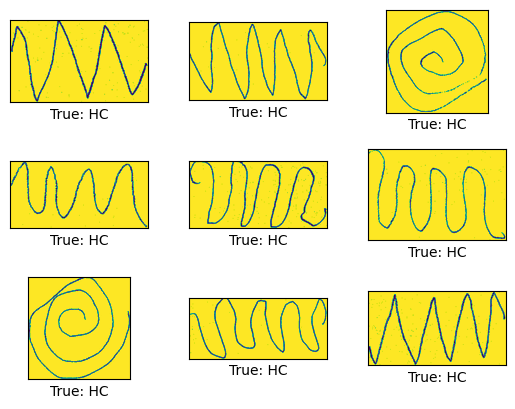

In [ ]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)
class_weight

array([1.15201192, 0.88342857])

In [ ]:
class_weight= {0:1.15201192, 1:0.88342857}

In [ ]:
class_names

['HC', 'PD']

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
transfer_layer = model.get_layer('block5_pool')
transfer_layer.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [ ]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(2, activation='softmax'))

In [ ]:
!pip install tensorflow keras

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
from keras.optimizers import SGD

learning_rate = 0.001  # Tasa de aprendizaje relativamente alta
momentum = 0.5
weight_decay = 0.0005

# Configurar el optimizador SGD con weight decay (versión legada)
optimizer = SGD(
    learning_rate=learning_rate,
    momentum=momentum,
    decay=weight_decay,
    nesterov=False
)


In [ ]:
loss = 'binary_crossentropy'
metrics = ['binary_accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1Score()]

In [ ]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [ ]:
conv_model.trainable = False
for layer in conv_model.layers:
    layer.trainable = False

In [ ]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [ ]:
from keras import backend as K
from keras.metrics import Metric

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = K.round(y_true)
        y_pred = K.round(y_pred)

        tp = K.sum(y_true * y_pred)
        fp = K.sum((1 - y_true) * y_pred)
        fn = K.sum(y_true * (1 - y_pred))

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + K.epsilon())
        recall = self.tp / (self.tp + self.fn + K.epsilon())
        f1 = 2 * precision * recall / (precision + recall + K.epsilon())
        return f1

    def reset_state(self):
        K.batch_set_value([(v, 0) for v in self.variables])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_binary_accuracy',
                           patience=10,                      
                           mode='max')

In [ ]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
from math import ceil
epochs = 15

In [ ]:
history = new_model.fit(generator_train,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        class_weight=class_weight,
                        validation_data=generator_test,
                         validation_steps=steps_test)

Epoch 1/30
154/154 [==============================] - 54s 278ms/step - loss: 1.5260 - binary_accuracy: 0.6507 - precision: 0.6507 - recall: 0.6507 - f1_score: 0.6507 - val_loss: 1.6424 - val_binary_accuracy: 0.6127 - val_precision: 0.6127 - val_recall: 0.6127 - val_f1_score: 0.6127
Epoch 2/30
154/154 [==============================] - 40s 262ms/step - loss: 0.6260 - binary_accuracy: 0.7406 - precision: 0.7406 - recall: 0.7406 - f1_score: 0.7406 - val_loss: 0.8648 - val_binary_accuracy: 0.6647 - val_precision: 0.6647 - val_recall: 0.6647 - val_f1_score: 0.6647
Epoch 3/30
154/154 [==============================] - 43s 277ms/step - loss: 0.5611 - binary_accuracy: 0.7303 - precision: 0.7303 - recall: 0.7303 - f1_score: 0.7303 - val_loss: 0.8051 - val_binary_accuracy: 0.7225 - val_precision: 0.7225 - val_recall: 0.7225 - val_f1_score: 0.7225
Epoch 4/30
154/154 [==============================] - 40s 257ms/step - loss: 0.5322 - binary_accuracy: 0.7542 - precision: 0.7542 - recall: 0.7542 - f1

KeyboardInterrupt: ignored

In [ ]:
lista_archivos = os.listdir('/content/aumented')
numero_imagenes = len(lista_archivos)
print("Número total de imágenes aumentadas:", numero_imagenes)

Número total de imágenes aumentadas: 29654


In [ ]:
plot_training_history(history)

NameError: ignored

In [ ]:
result = new_model.evaluate(generator_test, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

17/17 [==============================] - 1s 80ms/step - loss: 0.6501 - binary_accuracy: 0.8035 - precision_1: 0.8035 - recall_1: 0.8035 - f1_score: 0.8035
Test-set classification accuracy: 80.35%


In [ ]:
files=generator_test.filenames
class_dict=generator_test.class_indices # a dictionary of the form class name: class index
rev_dict={}
for key, value in class_dict.items():
    rev_dict[value]=key   # dictionary of the form class index: class name

In [ ]:
predictions = new_model.predict(generator_test)
for i, p in enumerate(predictions):
    index=np.argmax(p)
    klass=rev_dict[index]    
    prob=p[index]
    print('for file ', files[i], ' predicted class is ', klass,' with probability ',prob)

17/17 [==============================] - 2s 113ms/step


<ipython-input-2-b3d1733d2e13>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(images)


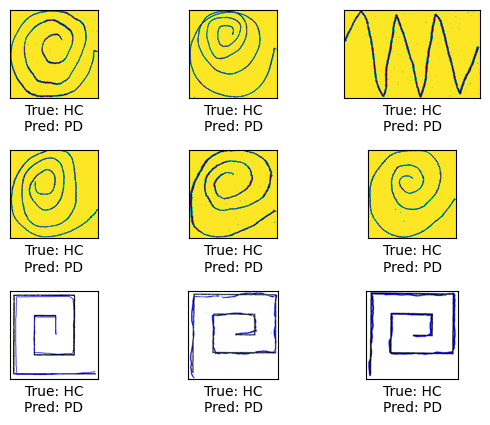

Confusion matrix:
[[54 21]
 [13 85]]
(0) HC
(1) PD


In [ ]:
example_errors()

In [ ]:
conv_model.trainable = True

In [ ]:
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name or 'block3' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

In [ ]:
print_layer_trainable()

False:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [ ]:
optimizer_fine = tf.keras.optimizers.experimental.SGD(
    learning_rate=0.0001,
    momentum=0.7,
    weight_decay=0.0005
)

In [ ]:
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

In [ ]:
history = new_model.fit(x=generator_train,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epochs,
                        class_weight=class_weight,
                        validation_data=generator_test,
                        validation_steps=steps_test)

Epoch 1/15
100/100 [==============================] - 33s 276ms/step - loss: 0.3672 - binary_accuracy: 0.8273 - precision: 0.8358 - recall: 0.8358 - val_loss: 0.3714 - val_binary_accuracy: 0.8671 - val_precision: 0.8671 - val_recall: 0.8671
Epoch 2/15
100/100 [==============================] - 25s 244ms/step - loss: 0.3432 - binary_accuracy: 0.8404 - precision: 0.8404 - recall: 0.8404 - val_loss: 0.3750 - val_binary_accuracy: 0.8902 - val_precision: 0.8902 - val_recall: 0.8902
Epoch 3/15
100/100 [==============================] - 22s 224ms/step - loss: 0.3534 - binary_accuracy: 0.8474 - precision: 0.8474 - recall: 0.8474 - val_loss: 0.3147 - val_binary_accuracy: 0.9017 - val_precision: 0.9017 - val_recall: 0.9017
Epoch 4/15
100/100 [==============================] - 23s 229ms/step - loss: 0.3053 - binary_accuracy: 0.8560 - precision: 0.8560 - recall: 0.8560 - val_loss: 0.2994 - val_binary_accuracy: 0.9075 - val_precision: 0.9075 - val_recall: 0.9075
Epoch 5/15
100/100 [================

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
def custom_scoring(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return accuracy_score(y_true, y_pred)

cv_scores = cross_val_score(new_model,generator_train, cv=5,scoring=custom_scoring)  # cv=5 indica 5 folds en la validación cruzada

# Imprimir los resultados
print("Accuracy medio: ", np.mean(cv_scores))
print("Accuracy por fold: ", cv_scores)

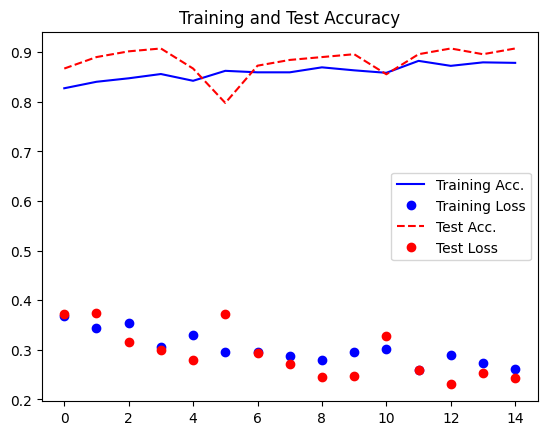

In [ ]:
plot_training_history(history)

In [ ]:
result = new_model.evaluate(generator_test, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

17/17 [==============================] - 2s 106ms/step - loss: 0.2426 - binary_accuracy: 0.9075 - precision: 0.9075 - recall: 0.9075
Test-set classification accuracy: 90.75%


17/17 [==============================] - 1s 76ms/step


<ipython-input-19-b3d1733d2e13>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(images)


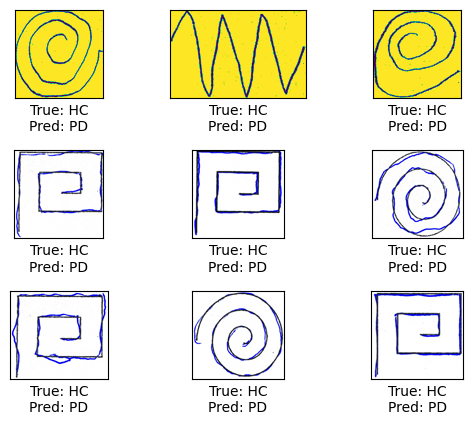

Confusion matrix:
[[65 10]
 [ 6 92]]
(0) HC
(1) PD


In [ ]:
example_errors()

In [ ]:
new_model.save('5_CNN_PD.h5')

In [ ]:
!zip -r '/content/first_CNN_PD.zip' '/content/first_CNN_PD'

In [ ]:
!zip -r '/content/first_CNN_PD.zip' '/content/first_CNN_PD'

In [ ]:
!mv '/content/first_CNN_PD.h5' '/content/gdrive/MyDrive/PD_Dataset'

In [ ]:
!mv '/content/first_CNN_PD.zip' '/content/gdrive/MyDrive/PD_Dataset'

In [ ]:
from keras import models    
model_new = models.load_model('/content/gdrive/MyDrive/PD_Dataset/4_CNN_PD.h5')

In [ ]:
model_new.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 40,407,874
Trainable params: 38,672,386
Non-trainable params: 1,735,488
_________________________________________________________________


In [ ]:
result = model_new.evaluate(generator_test, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

In [ ]:
files=generator_test.filenames
class_dict=generator_test.class_indices # a dictionary of the form class name: class index
rev_dict={}
for key, value in class_dict.items():
    rev_dict[value]=key   # dictionary of the form class index: class name

In [ ]:
predictions = new_model.predict(generator_test)
for i, p in enumerate(predictions):
    index=np.argmax(p)
    klass=rev_dict[index]    
    prob=p[index]
    print('for file ', files[i], ' predicted class is ', klass,' with probability ',prob)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import img_to_array

img = load_img('/content/a1hinn6hqggpbq0thyrd.png', target_size=(224, 224))
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)
cv2.imshow(img)

DisabledFunctionError: ignored

In [ ]:
!git clone https://github.com/jrowberg/i2cdevlib/tree/master/Arduino/MPU6050